In [ ]:
%load_ext rpy2.ipython

from utils import math_utils, sys_utils
import numpy as np
import os
import dci
import yaml

SAVE_FOLDER = 'data1/'
N_PAIRS = 100
N_SAMP = 1000
R = .05
A = .05
p = 10
s = 3./p

DUG_ALPHA = .001
DDAG_SKEL_ALPHAS = [.01, .1]
PCALG_ALPHAS = [.01, .1]
DDAG_ALPHA = .05

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Generate 100 random DAG pairs, with
 - p = 10 nodes
 - s = 3 expected neighbors per node
 - R = A = 5% addition and removal rate of edges

Also generate samples and save sample precision matrices in /data1

In [13]:
for i in range(N_PAIRS):
    sys_utils.ensure_dirs([
        SAVE_FOLDER + 'pair{}/Bs/'.format(i), 
        SAVE_FOLDER + 'pair{}/Xs/'.format(i), 
        SAVE_FOLDER + 'pair{}/sample_Ks/'.format(i)
    ])
    
    B1 = math_utils.random_dag(p, s)
    B2, changed_edges = math_utils.random_dag_changes(B1, r=R, a=A)
    np.savetxt(SAVE_FOLDER + 'pair{}/Bs/B1.txt'.format(i), B1)
    np.savetxt(SAVE_FOLDER + 'pair{}/Bs/B2.txt'.format(i), B2)
    
    X1 = math_utils.sample_dag(B1, N_SAMP)
    X2 = math_utils.sample_dag(B2, N_SAMP)
    sample_S1 = X1.T @ X1
    sample_S2 = X2.T @ X2
    sample_K1 = np.linalg.inv(sample_S1)
    sample_K2 = np.linalg.inv(sample_S2)
    np.savetxt(SAVE_FOLDER + 'pair{}/Xs/X1.txt'.format(i), X1)
    np.savetxt(SAVE_FOLDER + 'pair{}/Xs/X2.txt'.format(i), X2)
    np.savetxt(SAVE_FOLDER + 'pair{}/sample_Ks/K1.txt'.format(i), sample_K1)
    np.savetxt(SAVE_FOLDER + 'pair{}/sample_Ks/K2.txt'.format(i), sample_K2)

Estimate the D-UG, D-DAG skeleton, and D-DAG

In [14]:
verbose = False
for i in range(N_PAIRS):
    RES_FOLDER = SAVE_FOLDER + 'pair{}/dci_results/'.format(i)
    if not os.path.exists(RES_FOLDER):
        print('==== Estimating D-DAG for pair {} ===='.format(i))
        sys_utils.ensure_dirs([RES_FOLDER])
        B1 = np.loadtxt(SAVE_FOLDER + 'pair{}/Bs/B1.txt'.format(i))
        B2 = np.loadtxt(SAVE_FOLDER + 'pair{}/Bs/B2.txt'.format(i))
        X1 = np.loadtxt(SAVE_FOLDER + 'pair{}/Xs/X1.txt'.format(i))
        X2 = np.loadtxt(SAVE_FOLDER + 'pair{}/Xs/X2.txt'.format(i))
        sample_K1 = np.loadtxt(SAVE_FOLDER + 'pair{}/sample_Ks/K1.txt'.format(i))
        sample_K2 = np.loadtxt(SAVE_FOLDER + 'pair{}/sample_Ks/K2.txt'.format(i))

        est_dug, changed_nodes = dci.estimate_dug(sample_K1, sample_K2, N_SAMP, N_SAMP, alpha=DUG_ALPHA, verbose=verbose)
        retained_edges_dict, _ = dci.estimate_ddag_skeleton(X1, X2, est_dug, changed_nodes, DDAG_SKEL_ALPHAS, verbose=verbose)
        yaml.dump(sys_utils.listify_dict(retained_edges_dict), open(RES_FOLDER + 'estimated_ddag_skeletons.yaml', 'w'), indent=2)

        estimated_ddags = {}
        for alpha in DDAG_SKEL_ALPHAS:
            est_ddag = dci.estimate_ddag(X1, X2, retained_edges_dict[alpha], changed_nodes, DDAG_ALPHA, verbose=verbose)
            estimated_ddags[alpha] = est_ddag
        yaml.dump(sys_utils.listify_dict(estimated_ddags), open(RES_FOLDER + 'estimated_ddags.yaml', 'w'), indent=2)


==== Estimating D-DAG for pair 0 ====
==== Estimating D-DAG for pair 1 ====
==== Estimating D-DAG for pair 2 ====
==== Estimating D-DAG for pair 3 ====
==== Estimating D-DAG for pair 4 ====
==== Estimating D-DAG for pair 5 ====
==== Estimating D-DAG for pair 6 ====
==== Estimating D-DAG for pair 7 ====
==== Estimating D-DAG for pair 8 ====
==== Estimating D-DAG for pair 9 ====
==== Estimating D-DAG for pair 10 ====
==== Estimating D-DAG for pair 11 ====
==== Estimating D-DAG for pair 12 ====
==== Estimating D-DAG for pair 13 ====
==== Estimating D-DAG for pair 14 ====
==== Estimating D-DAG for pair 15 ====
==== Estimating D-DAG for pair 16 ====
==== Estimating D-DAG for pair 17 ====
==== Estimating D-DAG for pair 18 ====
==== Estimating D-DAG for pair 19 ====
==== Estimating D-DAG for pair 20 ====
==== Estimating D-DAG for pair 21 ====
==== Estimating D-DAG for pair 22 ====
==== Estimating D-DAG for pair 23 ====
==== Estimating D-DAG for pair 24 ====
==== Estimating D-DAG for pair 25 =

In [71]:
%%R -i N_PAIRS,SAVE_FOLDER,PCALG_ALPHAS

library('pcalg')
library('GetoptLong')

for (i in 0:(N_PAIRS-1)) {
    X1 = read.table(qq('@{SAVE_FOLDER}pair@{i}/Xs/X1.txt'))
    X2 = read.table(qq('@{SAVE_FOLDER}pair@{i}/Xs/X2.txt'))
    S1 = list(C = cor(X1), n = nrow(X1))
    S2 = list(C = cor(X2), n = nrow(X2))
    
    for (alpha in PCALG_ALPHAS) {
        RES_FOLDER = qq('@{SAVE_FOLDER}pair@{i}/pcalg_results/alpha=@{alpha}/')
        dir.create(RES_FOLDER, recursive=TRUE)
        skel1 = pc(suffStat = S1, indepTest=gaussCItest, alpha=alpha, labels=colnames(X1))
        skel2 = pc(suffStat = S2, indepTest=gaussCItest, alpha=alpha, labels=colnames(X2))
        write(as(skel1, 'amat'), file=qq('@{RES_FOLDER}A1.txt'), ncolumns=ncol(X1))
        write(as(skel2, 'amat'), file=qq('@{RES_FOLDER}A2.txt'), ncolumns=ncol(X2))
    }
}

In [35]:
rates_skel = {
    'tprs': np.zeros([N_PAIRS, len(DDAG_SKEL_ALPHAS)]),
    'tnrs': np.zeros([N_PAIRS, len(DDAG_SKEL_ALPHAS)]),
    'fprs': np.zeros([N_PAIRS, len(DDAG_SKEL_ALPHAS)]),
    'fnrs': np.zeros([N_PAIRS, len(DDAG_SKEL_ALPHAS)])
}

for i in range(N_PAIRS):
    print("=== COMPUTING TP/TN/FP/FN RATES FOR DAG PAIR {} ===".format(i))
    RES_FOLDER = SAVE_FOLDER + 'pair{}/dci_results/'.format(i)
    B1 = np.loadtxt(SAVE_FOLDER + 'pair{}/Bs/B1.txt'.format(i))
    B2 = np.loadtxt(SAVE_FOLDER + 'pair{}/Bs/B2.txt'.format(i))
    actual_edges = set(math_utils.upper_tri_ixs_nonzero(B1 - B2))
    actual_no_edges = set(math_utils.upper_tri_ixs_zero(B1 - B2))
    
    est_ddag_skeletons = sys_utils.setify_dict(yaml.load(open(RES_FOLDER + 'estimated_ddag_skeletons.yaml')))
    est_ddags = sys_utils.setify_dict(yaml.load(open(RES_FOLDER + 'estimated_ddags.yaml')))
    
    for j, alpha in enumerate(DDAG_SKEL_ALPHAS):
        true_pos, true_neg, false_pos, false_neg = math_utils.sort_pos_neg(est_ddag_skeletons[alpha], actual_edges, actual_no_edges)
        tpr, tnr, fpr, fnr = math_utils.compute_pos_neg_rates(true_pos, true_neg, false_pos, false_neg)
        rates_skel['tprs'][i, j] = tpr
        rates_skel['tnrs'][i, j] = tnr
        rates_skel['fprs'][i, j] = fpr
        rates_skel['fnrs'][i, j] = fnr

avg_tprs = rates_skel['tprs'].mean(axis=0)
avg_fprs = rates_skel['fprs'].mean(axis=0)
exactly_correct = np.logical_and(rates_skel['fprs'] == 0, rates_skel['fnrs'] == 0)
prop_exactly_correct = exactly_correct.sum(axis=0) / N_PAIRS

=== COMPUTING TP/TN/FP/FN RATES FOR DAG PAIR 0 ===
=== COMPUTING TP/TN/FP/FN RATES FOR DAG PAIR 1 ===
=== COMPUTING TP/TN/FP/FN RATES FOR DAG PAIR 2 ===
=== COMPUTING TP/TN/FP/FN RATES FOR DAG PAIR 3 ===
=== COMPUTING TP/TN/FP/FN RATES FOR DAG PAIR 4 ===
=== COMPUTING TP/TN/FP/FN RATES FOR DAG PAIR 5 ===
=== COMPUTING TP/TN/FP/FN RATES FOR DAG PAIR 6 ===
=== COMPUTING TP/TN/FP/FN RATES FOR DAG PAIR 7 ===
=== COMPUTING TP/TN/FP/FN RATES FOR DAG PAIR 8 ===
=== COMPUTING TP/TN/FP/FN RATES FOR DAG PAIR 9 ===
=== COMPUTING TP/TN/FP/FN RATES FOR DAG PAIR 10 ===
=== COMPUTING TP/TN/FP/FN RATES FOR DAG PAIR 11 ===
=== COMPUTING TP/TN/FP/FN RATES FOR DAG PAIR 12 ===
=== COMPUTING TP/TN/FP/FN RATES FOR DAG PAIR 13 ===
=== COMPUTING TP/TN/FP/FN RATES FOR DAG PAIR 14 ===
=== COMPUTING TP/TN/FP/FN RATES FOR DAG PAIR 15 ===
=== COMPUTING TP/TN/FP/FN RATES FOR DAG PAIR 16 ===
=== COMPUTING TP/TN/FP/FN RATES FOR DAG PAIR 17 ===
=== COMPUTING TP/TN/FP/FN RATES FOR DAG PAIR 18 ===
=== COMPUTING TP/TN/FP

(0, 1)

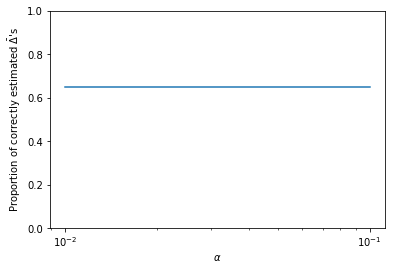

In [36]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(DDAG_SKEL_ALPHAS, prop_exactly_correct)
plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r"Proportion of correctly estimated $\bar{\Delta}$'s")
plt.ylim([0, 1])